In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

In [4]:
# Start Spark Session
spark = SparkSession.builder.appName("CrimeDataEDA").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 11:26:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/18 11:26:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
file_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"

df = spark.read.option("header", "true").csv(file_path)
df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+-----

24/10/18 11:26:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
print(df.dtypes)

[('DR_NO', 'string'), ('Date Rptd', 'string'), ('DATE OCC', 'string'), ('TIME OCC', 'string'), ('AREA', 'string'), ('AREA NAME', 'string'), ('Rpt Dist No', 'string'), ('Part 1-2', 'string'), ('Crm Cd', 'string'), ('Crm Cd Desc', 'string'), ('Mocodes', 'string'), ('Vict Age', 'string'), ('Vict Sex', 'string'), ('Vict Descent', 'string'), ('Premis Cd', 'string'), ('Premis Desc', 'string'), ('Weapon Used Cd', 'string'), ('Weapon Desc', 'string'), ('Status', 'string'), ('Status Desc', 'string'), ('Crm Cd 1', 'string'), ('Crm Cd 2', 'string'), ('Crm Cd 3', 'string'), ('Crm Cd 4', 'string'), ('LOCATION', 'string'), ('Cross Street', 'string'), ('LAT', 'string'), ('LON', 'string')]


In [5]:
columns = df.columns
print(columns)

['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [6]:
print(len(columns))

28


24/10/13 15:47:48 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
# Find the difference between date reported and date occurred
df = df.withColumn("dt_reported", F.to_date("Date Rptd", "MM/dd/yyyy hh:mm:ss a"))
df = df.withColumn("dt_occurred", F.to_date("DATE OCC", "MM/dd/yyyy hh:mm:ss a"))

df = df.withColumn("lag_time", F.date_diff("dt_reported", "dt_occurred").cast("float"))

df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+-----------+-----------+--------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|dt_reported|dt_occurred|lag_time|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+----------------

In [8]:
df.dtypes

[('DR_NO', 'string'),
 ('Date Rptd', 'string'),
 ('DATE OCC', 'string'),
 ('TIME OCC', 'string'),
 ('AREA', 'string'),
 ('AREA NAME', 'string'),
 ('Rpt Dist No', 'string'),
 ('Part 1-2', 'string'),
 ('Crm Cd', 'string'),
 ('Crm Cd Desc', 'string'),
 ('Mocodes', 'string'),
 ('Vict Age', 'string'),
 ('Vict Sex', 'string'),
 ('Vict Descent', 'string'),
 ('Premis Cd', 'string'),
 ('Premis Desc', 'string'),
 ('Weapon Used Cd', 'string'),
 ('Weapon Desc', 'string'),
 ('Status', 'string'),
 ('Status Desc', 'string'),
 ('Crm Cd 1', 'string'),
 ('Crm Cd 2', 'string'),
 ('Crm Cd 3', 'string'),
 ('Crm Cd 4', 'string'),
 ('LOCATION', 'string'),
 ('Cross Street', 'string'),
 ('LAT', 'string'),
 ('LON', 'string'),
 ('dt_reported', 'date'),
 ('dt_occurred', 'date'),
 ('lag_time', 'float')]

In [9]:
df.describe("lag_time").show()

+-------+------------------+
|summary|          lag_time|
+-------+------------------+
|  count|            982638|
|   mean|11.859455872864677|
| stddev| 66.83719170423053|
|    min|               0.0|
|    max|            1711.0|
+-------+------------------+



In [10]:
df = df.withColumn("year_occurred", F.year("dt_occurred"))
df = df.withColumn("month_occurred", F.month("dt_occurred"))
df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+-----------+-----------+--------+-------------+--------------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|dt_reported|dt_occurred|lag_time|year_occurred|month_occurred|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------

In [20]:
# df.select("Vict Sex").distinct().show()
# df.filter(df["Vict Sex"].isNull()).select("Vict Sex").show()
df = df.fillna({'Vict Sex': 'X'})
df.filter(df["Vict Sex"].isNull()).select("Vict Sex").count()
# df.filter(df['Vict Sex'] == "-").count()
df_updated = df.withColumn("Vict Sex", F.when(df["Vict Sex"] == "H", "X").otherwise(df["Vict Sex"]))
df_updated.filter(df_updated['Vict Sex'] == "H").count()


0

In [11]:
df_grouped = df.groupBy("year_occurred", "month_occurred").agg(F.count("month_occurred").alias("frequency"))
df_grouped.show()

+-------------+--------------+---------+
|year_occurred|month_occurred|frequency|
+-------------+--------------+---------+
|         2020|             6|    17056|
|         2020|            11|    15590|
|         2020|             3|    16187|
|         2020|             9|    15654|
|         2020|            12|    15976|
|         2020|             4|    15701|
|         2020|             1|    18560|
|         2020|             8|    16897|
|         2020|             7|    17153|
|         2020|             2|    17278|
|         2020|            10|    16507|
|         2020|             5|    17228|
|         2021|            10|    19335|
|         2021|            11|    18367|
|         2021|            12|    17957|
|         2021|             7|    18684|
|         2021|             2|    15435|
|         2021|             8|    18395|
|         2021|             6|    17180|
|         2021|             5|    17016|
+-------------+--------------+---------+
only showing top

In [12]:
years = df.select("year_occurred").distinct()
years_list = [row['year_occurred'] for row in years.collect()]
print(years_list)

[2020, 2021, 2022, 2023, 2024]


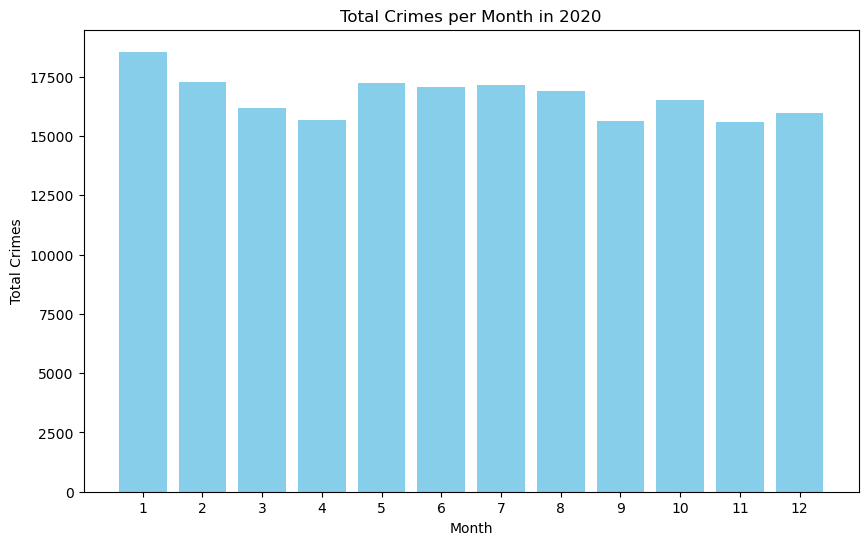

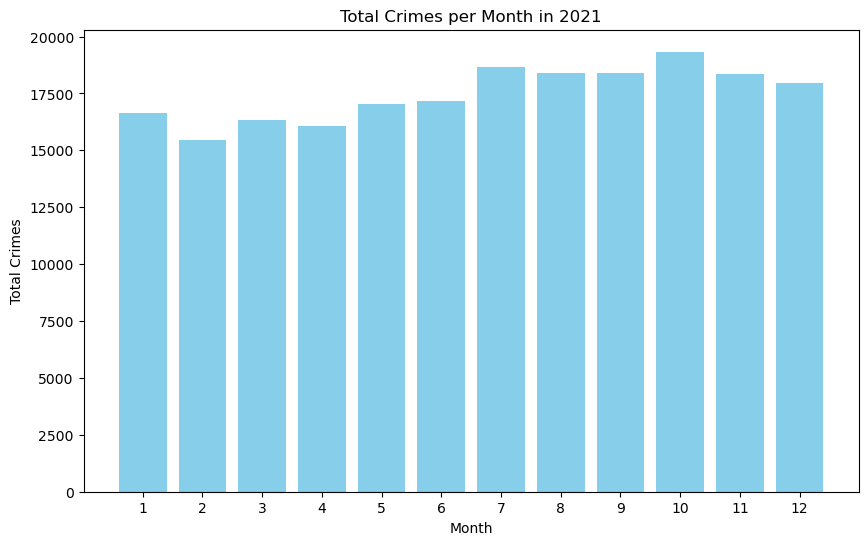

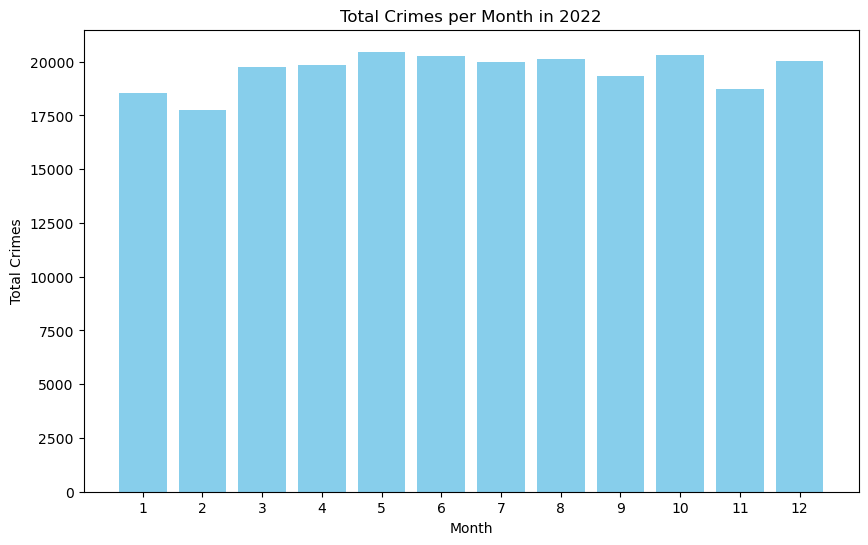

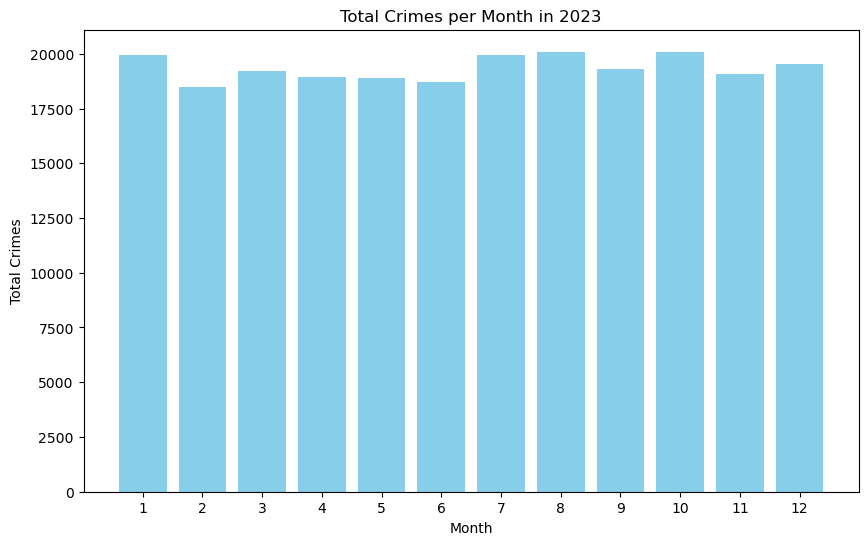

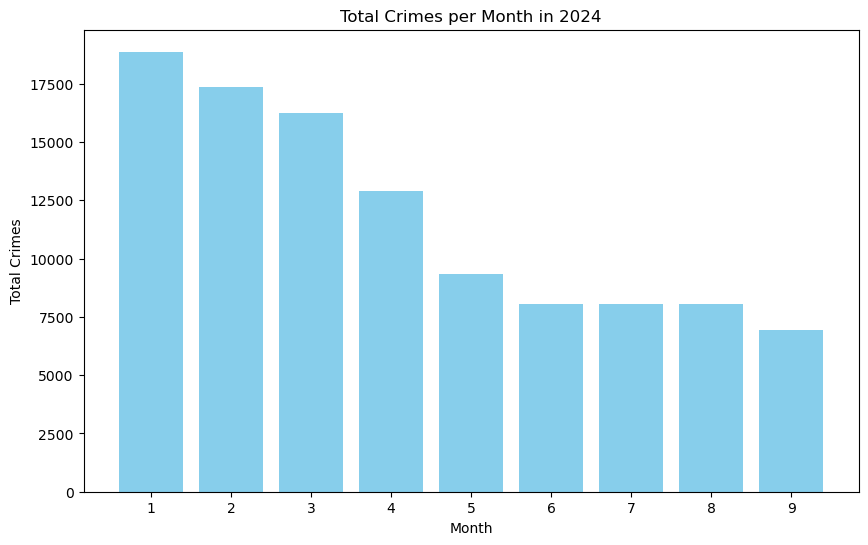

In [13]:
for yr in years_list:
    df_year = df_grouped.filter(df_grouped.year_occurred == yr)
    data_year = df_year.collect()

    months = [row["month_occurred"] for row in data_year]
    total_crimes = [row['frequency'] for row in data_year]

    plt.figure(figsize=(10,6))
    plt.bar(months, total_crimes, color='skyblue')
    plt.xlabel("Month")
    plt.ylabel("Total Crimes")
    plt.title(f"Total Crimes per Month in {yr}")
    plt.xticks(months)
    plt.show()

Crime frequency for each month is about the same.

In [14]:
df_year_total = df.groupBy("year_occurred").agg(F.count("year_occurred").alias("total_each_year"))
df_year_total.show()

+-------------+---------------+
|year_occurred|total_each_year|
+-------------+---------------+
|         2020|         199787|
|         2021|         209805|
|         2022|         235152|
|         2023|         232130|
|         2024|         105764|
+-------------+---------------+



The number of crimes is increasing from 2020 to 2022 but decrease in 2023. Not a lot by decrease. 

The number in year 2024 is not complete. 

In [15]:
# grouping the crime according to crime code etc
df_crime_cat = df.groupBy("year_occurred", "Crm Cd Desc").agg(F.count("year_occurred").alias("crime_cat_by_year")).orderBy("crime_cat_by_year", ascending=False)
df_crime_cat.show()

+-------------+--------------------+-----------------+
|year_occurred|         Crm Cd Desc|crime_cat_by_year|
+-------------+--------------------+-----------------+
|         2022|    VEHICLE - STOLEN|            24742|
|         2023|    VEHICLE - STOLEN|            24464|
|         2021|    VEHICLE - STOLEN|            23683|
|         2022|   THEFT OF IDENTITY|            22130|
|         2020|    VEHICLE - STOLEN|            20771|
|         2023|BATTERY - SIMPLE ...|            18834|
|         2022|BATTERY - SIMPLE ...|            18058|
|         2024|    VEHICLE - STOLEN|            17144|
|         2020|BATTERY - SIMPLE ...|            16331|
|         2021|BATTERY - SIMPLE ...|            16199|
|         2023|            BURGLARY|            14287|
|         2022|BURGLARY FROM VEH...|            14231|
|         2022|            BURGLARY|            14069|
|         2021|VANDALISM - FELON...|            13681|
|         2023|BURGLARY FROM VEH...|            13556|
|         

In [16]:
# grouping the crime according to crime code etc
df_crime_cat = df.groupBy("year_occurred", "Crm Cd Desc").agg(F.count("year_occurred").alias("crime_cat_by_year")).orderBy(["year_occurred", "crime_cat_by_year"])
df_crime_cat.show()

+-------------+--------------------+-----------------+
|year_occurred|         Crm Cd Desc|crime_cat_by_year|
+-------------+--------------------+-----------------+
|         2020|             BRIBERY|                1|
|         2020|GRAND THEFT / AUT...|                1|
|         2020|FIREARMS RESTRAIN...|                1|
|         2020| PICKPOCKET, ATTEMPT|                1|
|         2020|TILL TAP - GRAND ...|                2|
|         2020|GRAND THEFT / INS...|                2|
|         2020|PURSE SNATCHING -...|                3|
|         2020|BIKE - ATTEMPTED ...|                3|
|         2020|THEFT, COIN MACHI...|                3|
|         2020|   CHILD ABANDONMENT|                3|
|         2020|LYNCHING - ATTEMPTED|                4|
|         2020|PETTY THEFT - AUT...|                4|
|         2020|MANSLAUGHTER, NEG...|                4|
|         2020|TILL TAP - PETTY ...|                4|
|         2020|          DRUNK ROLL|                4|
|         

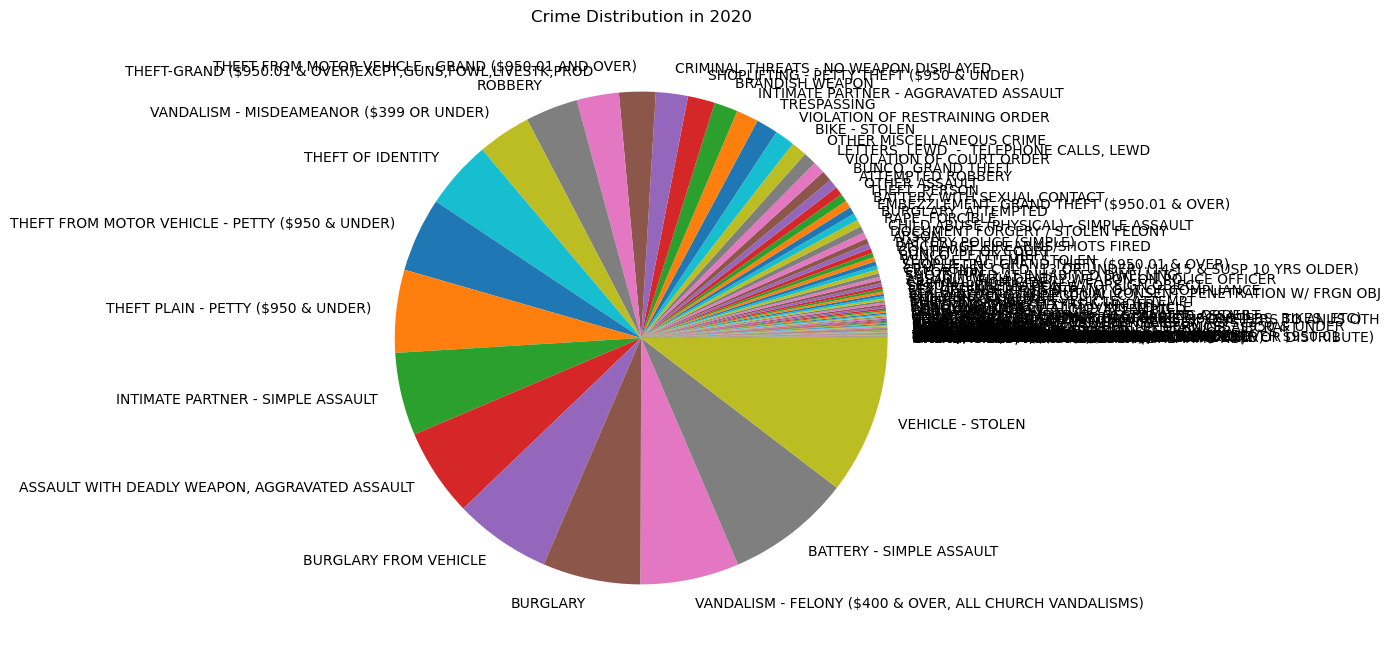

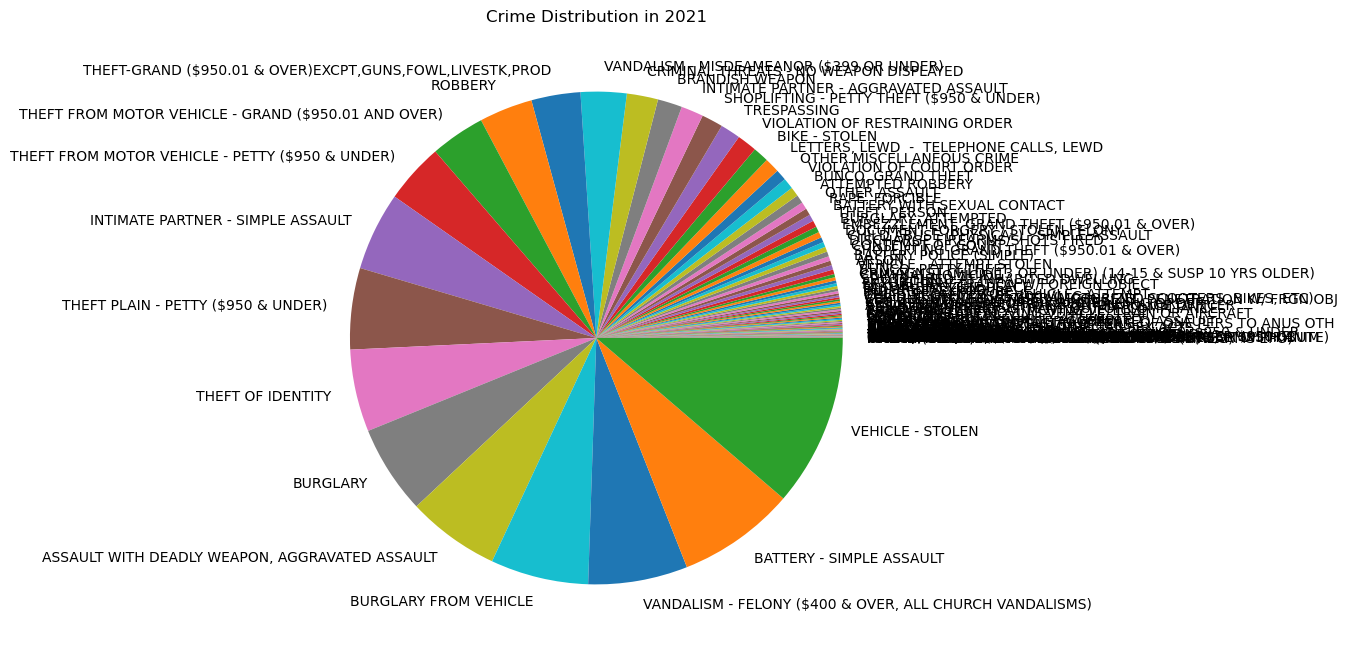

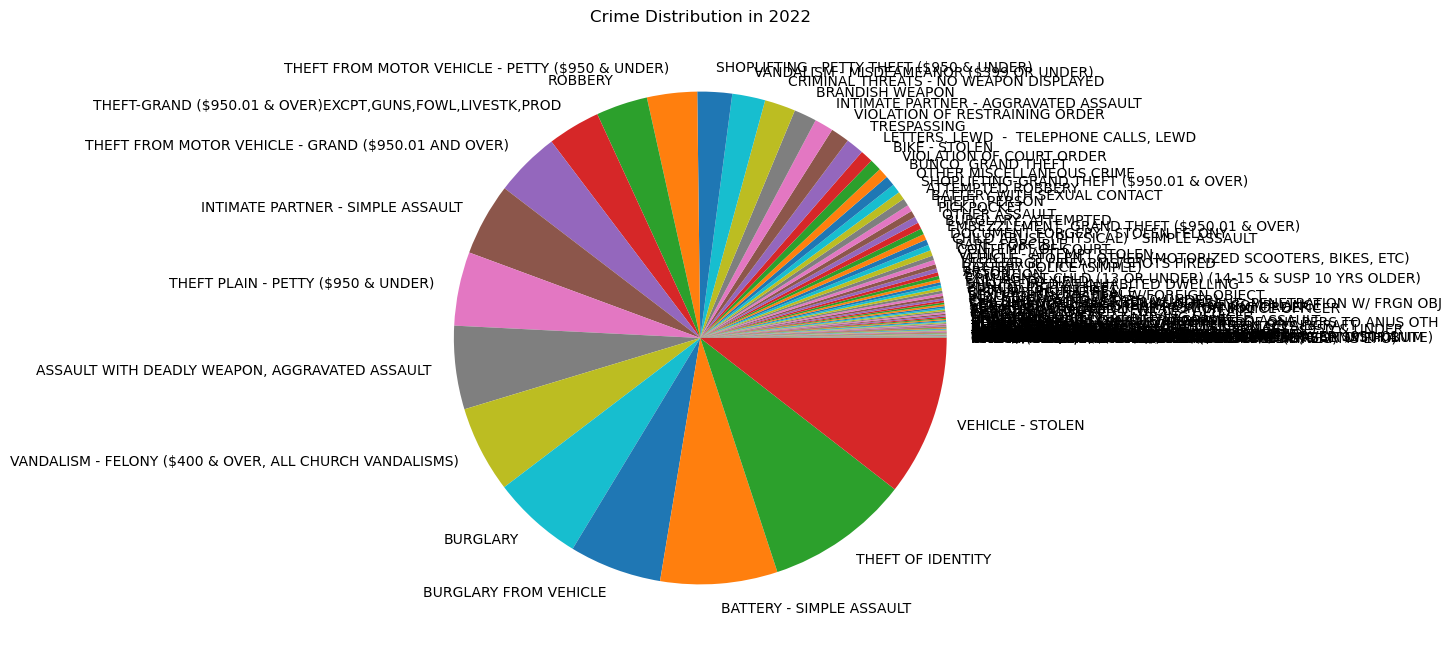

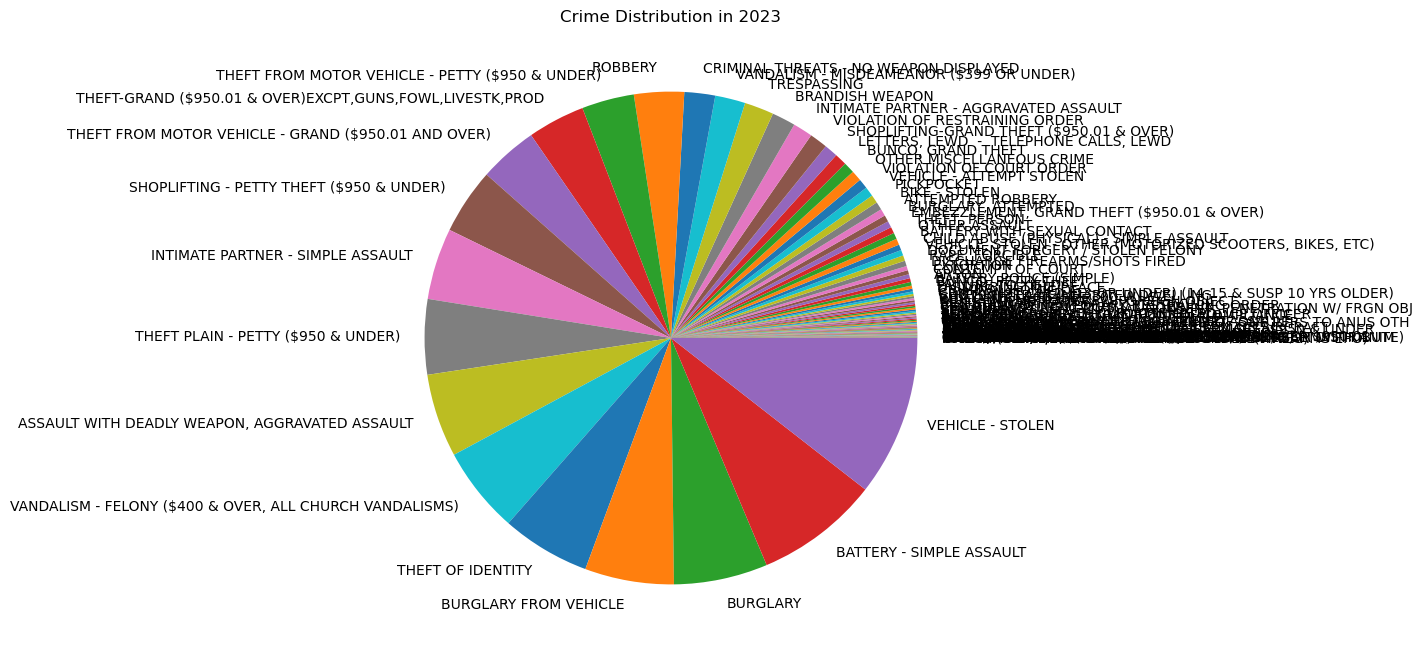

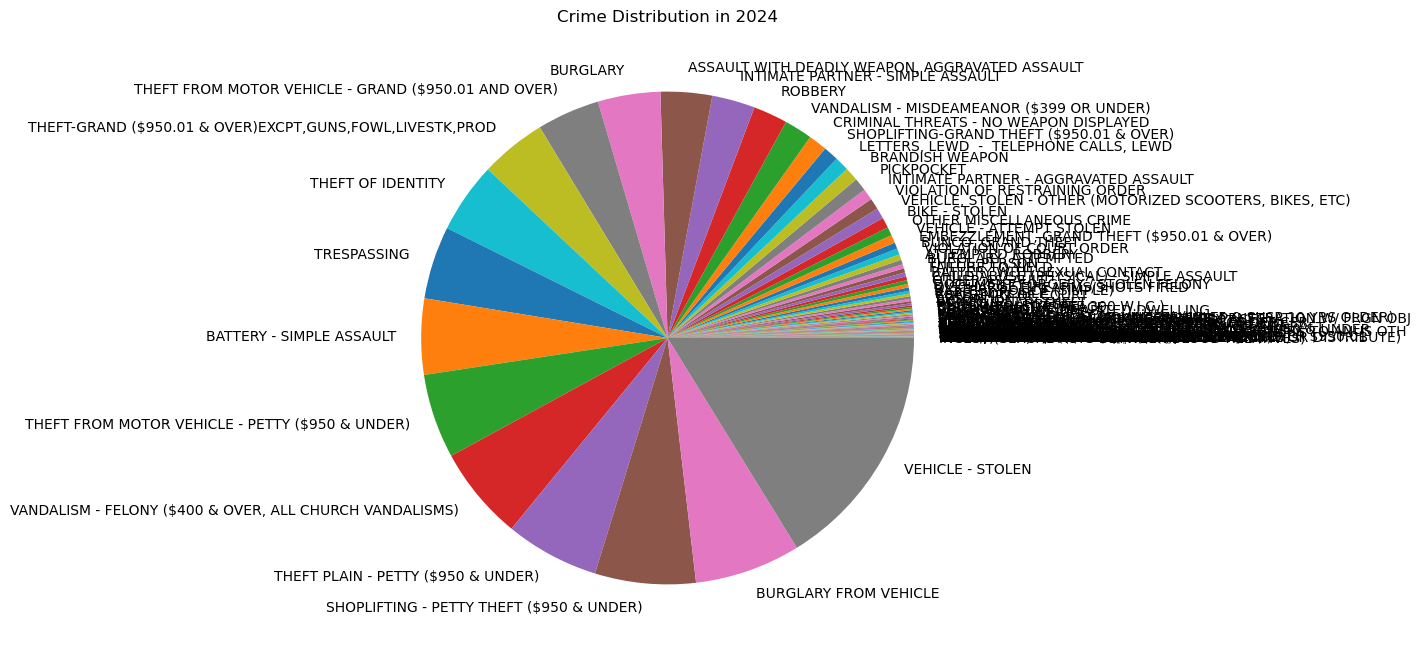

In [17]:
for yr in years_list:
    df_crime_year = df_crime_cat.filter(df_crime_cat.year_occurred == yr)
    data_crime_year = df_crime_year.collect()

    labels = [row["Crm Cd Desc"] for row in data_crime_year]
    sizes = [row['crime_cat_by_year'] for row in data_crime_year]

    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels)
    plt.title(f"Crime Distribution in {yr}")
    plt.show()

In [25]:
m = folium.Map(location=[34.0522, -118.2437], zoom_start=15)

df_2020 = df.filter(df.year_occurred == 2020) #.filter(df["Crm Cd"] == "110")
print(df_2020.count())
lat_lon_data = df_2020.select("LAT", "LON").rdd.map(lambda row: (row[0], row[1])).collect()

HeatMap(lat_lon_data).add_to(m)

m

199787


As we can see the crime is aggregated across all area. Perhaps we need to break it down into area-specific since in the database it is provided the area and its area name for each report. 

In [24]:
# Perhaps group by the area then see what are the types of crimes happening
df_crime_cat_area = df.groupBy("year_occurred","AREA NAME", "Crm Cd Desc").agg(F.count("year_occurred").alias("crime_cat_by_year_area")).orderBy(["year_occurred", "AREA NAME"], ascending=False)
df_crime_cat_area.show()

+-------------+---------+--------------------+----------------------+
|year_occurred|AREA NAME|         Crm Cd Desc|crime_cat_by_year_area|
+-------------+---------+--------------------+----------------------+
|         2024| Wilshire|          KIDNAPPING|                     1|
|         2024| Wilshire|ASSAULT WITH DEAD...|                    97|
|         2024| Wilshire|THEFT FROM MOTOR ...|                   281|
|         2024| Wilshire|SEX OFFENDER REGI...|                    17|
|         2024| Wilshire|DOCUMENT FORGERY ...|                     5|
|         2024| Wilshire|             ROBBERY|                    96|
|         2024| Wilshire|         TRESPASSING|                    66|
|         2024| Wilshire|INTIMATE PARTNER ...|                    75|
|         2024| Wilshire|    VEHICLE - STOLEN|                   642|
|         2024| Wilshire|WEAPONS POSSESSIO...|                     1|
|         2024| Wilshire|VIOLATION OF REST...|                    17|
|         2024| Wils

In [59]:
area = df.select("AREA NAME").distinct()
area_list = [row['AREA NAME'] for row in area.collect()]
print(area_list)
print(len(area_list))

['Hollywood', 'Harbor', 'Devonshire', 'N Hollywood', 'Newton', 'Van Nuys', 'West Valley', 'Mission', 'Southeast', 'Wilshire', 'Topanga', 'Central', 'Pacific', 'Hollenbeck', 'Olympic', 'Southwest', 'Foothill', 'Rampart', 'West LA', '77th Street', 'Northeast']
21


There are a total of 21 area, and each area is handled by a precinct. So we will divide the area for hotspot analysis. 

In [31]:
m = folium.Map(location=[34.0522, -118.2437], zoom_start=15)

df_2020_area = df.filter(df.year_occurred == 2020).filter(df["AREA"] == "07")
print(df_2020_area.count())
lat_lon_data = df_2020_area.select("LAT", "LON").rdd.map(lambda row: (row[0], row[1])).collect()

HeatMap(lat_lon_data).add_to(m)
m

9291


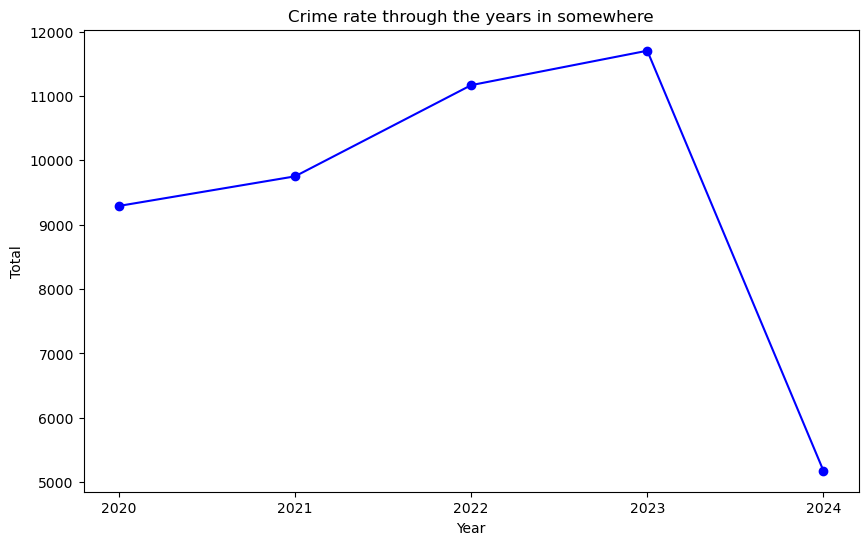

In [52]:
years = [2020, 2021, 2022, 2023, 2024]

df_area = df.filter(df["AREA"] == "07").select(["year_occurred"]).groupBy("year_occurred").count()
pdf = df_area.toPandas()
pdf["year_occurred"] = pd.to_datetime(pdf['year_occurred'], format="%Y").dt.year
pdf = pdf.sort_values(by="year_occurred")

plt.figure(figsize=(10, 6))
plt.plot(pdf['year_occurred'], pdf["count"], marker='o', linestyle='-', color='b')
plt.title("Crime rate through the years in somewhere")
plt.xlabel("Year")
plt.ylabel("Total")
plt.xticks(pdf['year_occurred'])
plt.show()




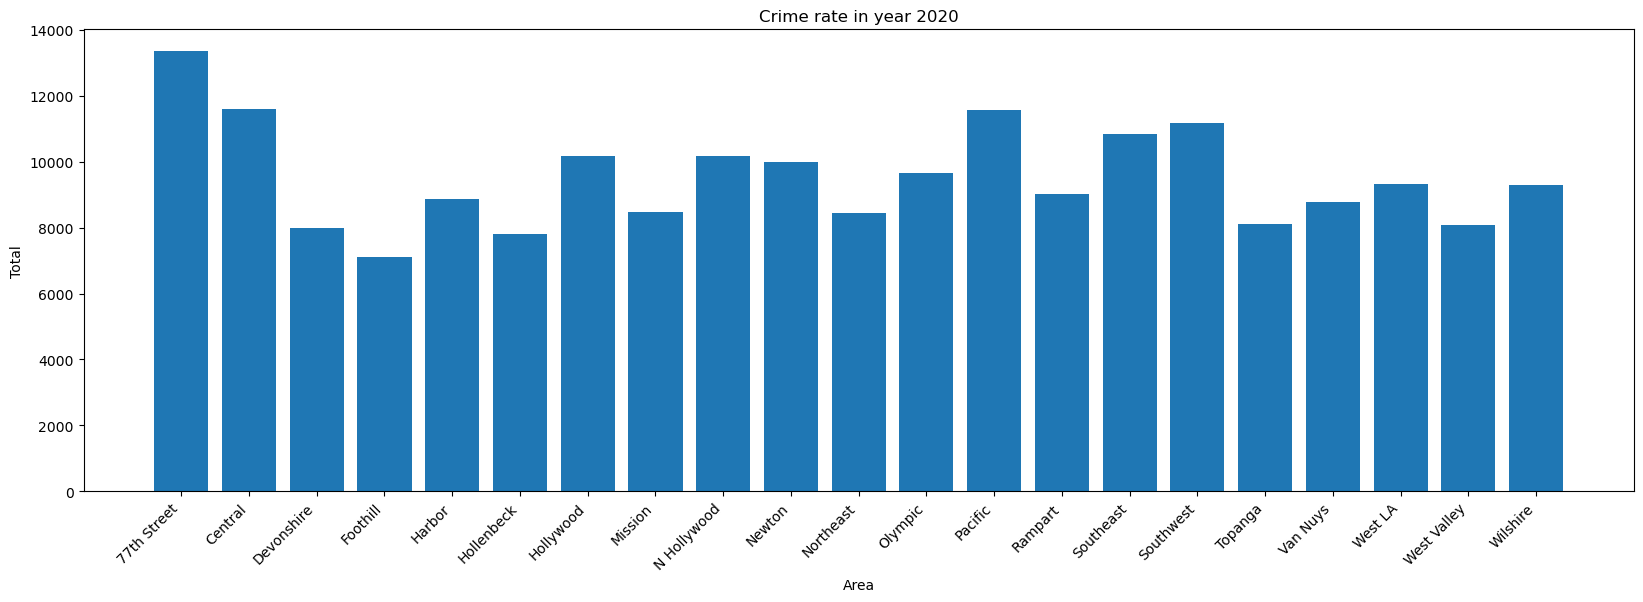

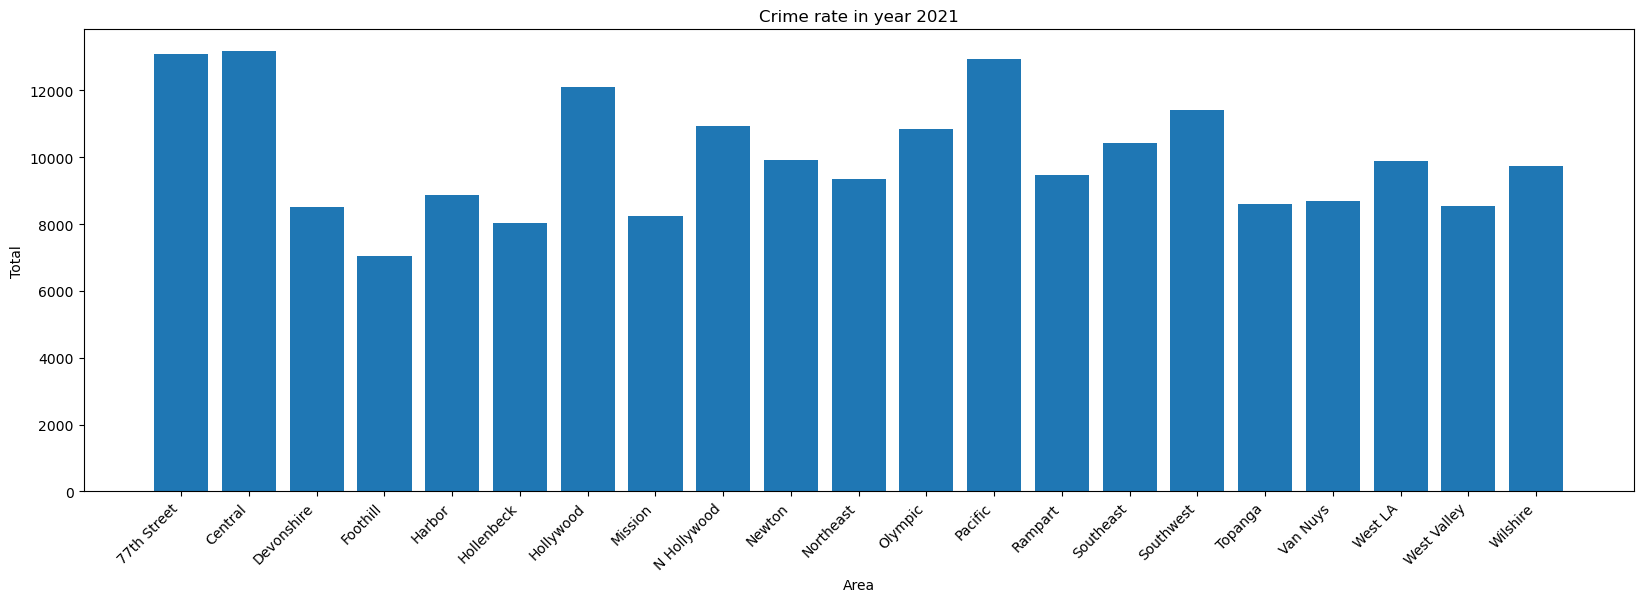

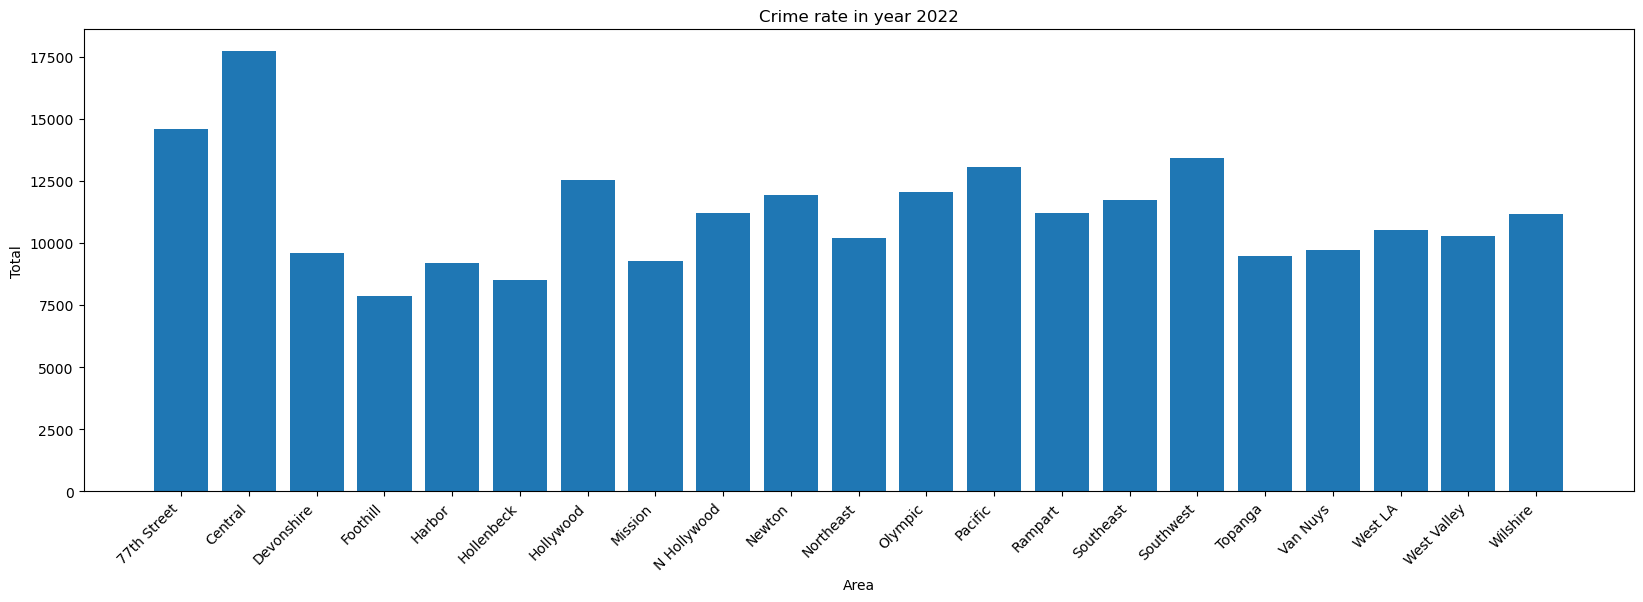

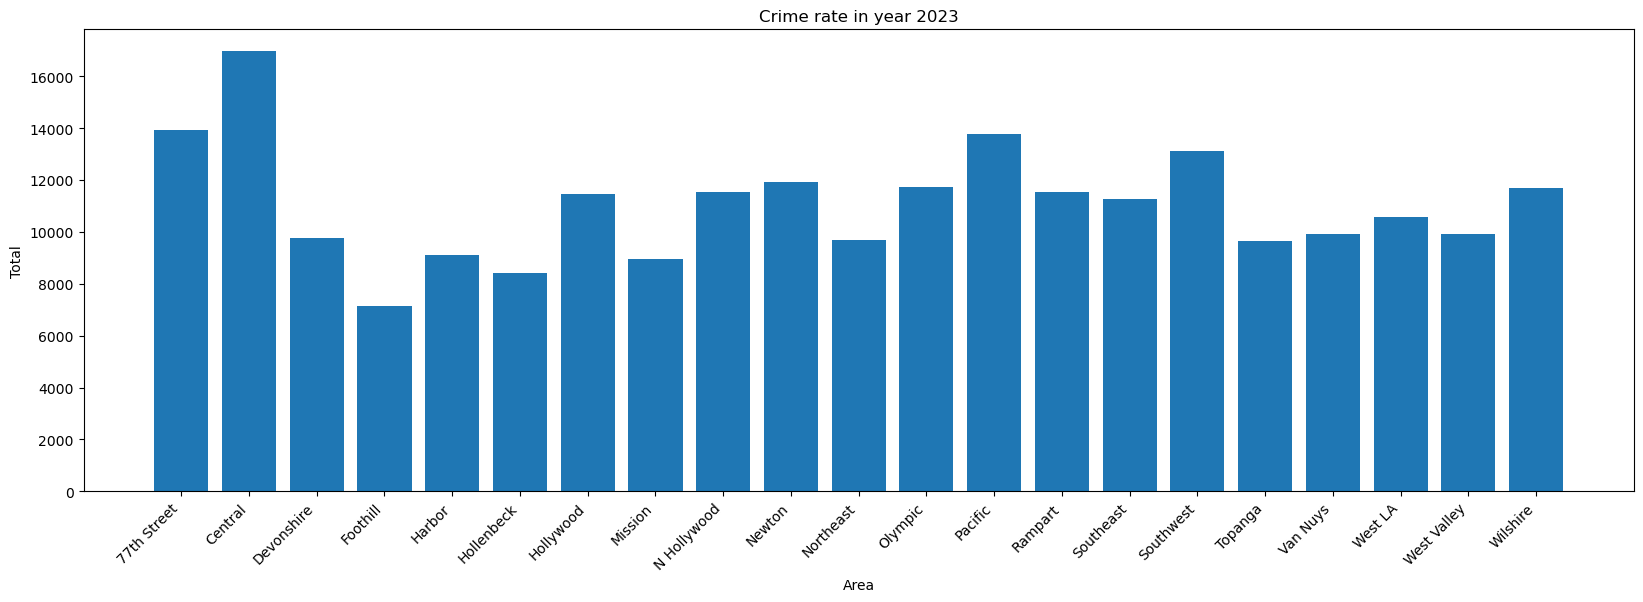

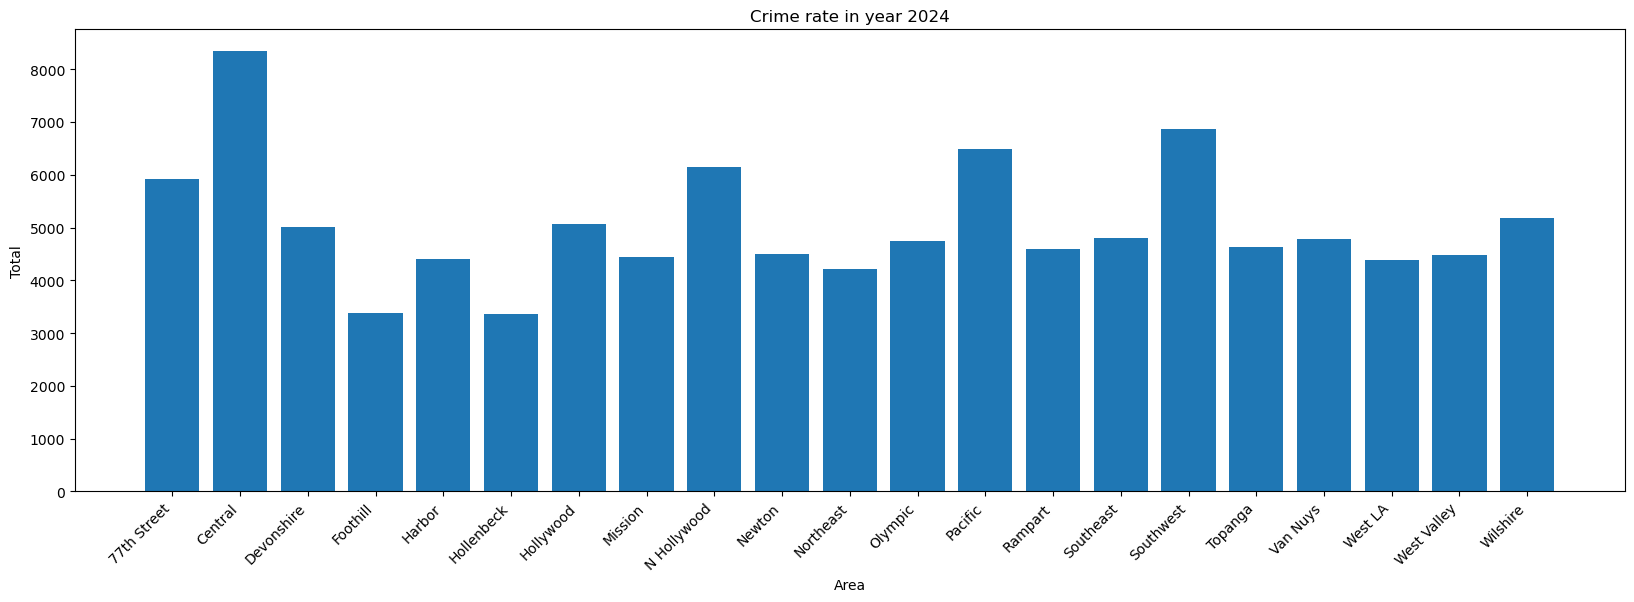

In [62]:
years = [2020, 2021, 2022, 2023, 2024]

for yr in years: 
    df_area = df.filter(df["year_occurred"] == yr).groupBy("AREA NAME").count()
    pdf = df_area.toPandas()
    pdf = pdf.sort_values(by=["AREA NAME", "count"])
    plt.figure(figsize=(20, 6))
    plt.bar(pdf["AREA NAME"], pdf["count"])
    plt.title(f"Crime rate in year {yr}")
    plt.xlabel("Area")
    plt.ylabel("Total")
    plt.xticks(pdf['AREA NAME'], rotation=45, ha="right")
    plt.show()



In [71]:
df_area = df.select("year_occurred", "AREA NAME").groupBy(["AREA NAME", "year_occurred"]).count()
pdf = df_area.toPandas()
pdf["year_occurred"] = pd.to_datetime(pdf['year_occurred'], format="%Y").dt.year
pdf = pdf.sort_values(by="year_occurred")
pdf.head()

AREA NAME  year_occurred  count
0      Van Nuys           2020   8763
20     Foothill           2020   7105
19  77th Street           2020  13341
18      Central           2020  11599
17      Mission           2020   8479

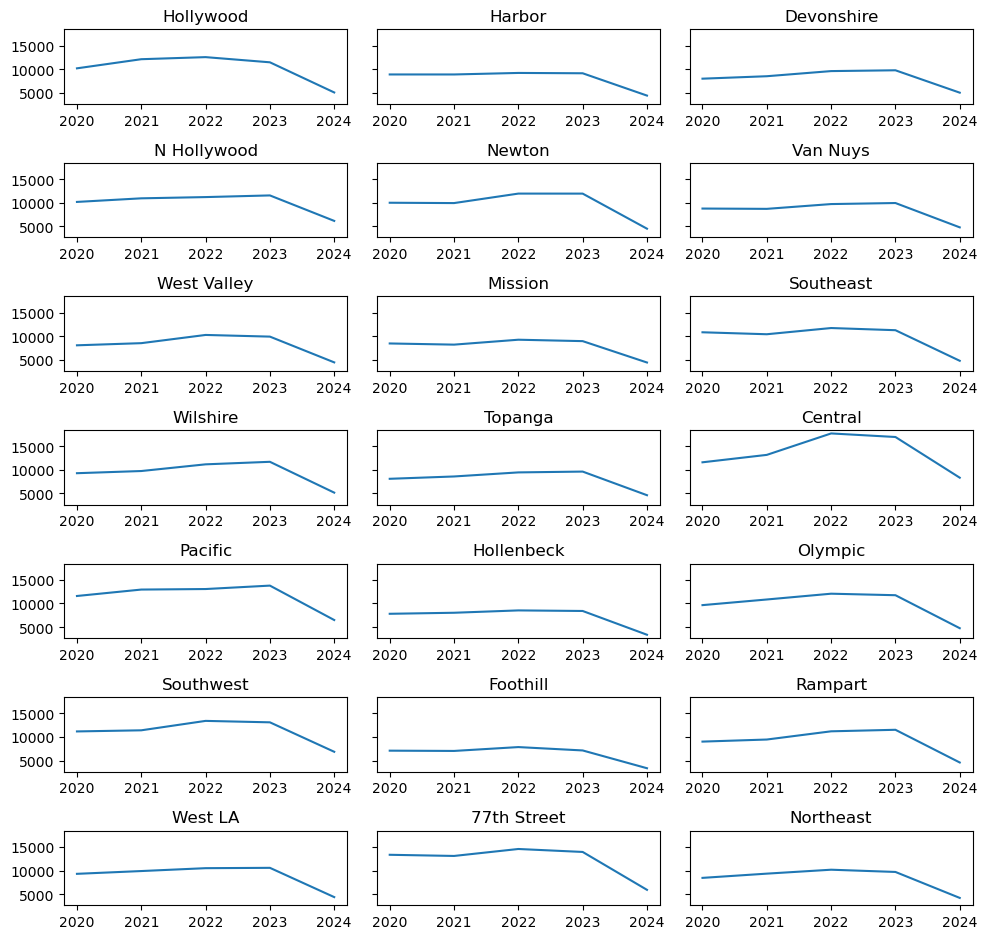

24/10/14 16:52:52 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 202727 ms exceeds timeout 120000 ms
24/10/14 16:52:52 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/14 16:52:53 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [80]:
fig, axes = plt.subplots(7, 3, figsize=(10, 10), sharey=True)
axes = axes.flatten()
for i, area in enumerate(area_list):
    df_subarea = pdf[pdf["AREA NAME"] == area]
    axes[i].set_title(f"{area}")
    axes[i].plot(df_subarea["year_occurred"], df_subarea["count"])
    
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
